In [ ]:
!git clone https://github.com/DrYogurt/Aero-Design-Team-Gamma.git
!pip install poetry==1.4.2

In [ ]:
%cd Aero-Design-Team-Gamma
!poetry config virtualenvs.in-project true
!poetry install --no-ansi

In [ ]:
VENV_PATH = "/content/Aero-Design-Team-Gamma/.venv/lib/python3.11/site-packages"
import os, sys
LOCAL_VENV_PATH = '/content/venv' # local notebook
os.symlink(VENV_PATH, LOCAL_VENV_PATH) # connect to directory in drive
sys.path.insert(0, LOCAL_VENV_PATH)

# Stability Trade Studies
We begin by creating the aircraft and setting it's mass/ moments of inertia

In [1]:
from aircraft_design.final_design.final_construction import Aircraft
from aircraft_design.analysis.mass_analysis import MassAnalysis, MassFeature
import copy
from pprint import pprint

aircraft = Aircraft()


mass_lb = 593638.11
cg_x_in = 1564.92
cg_y_in = 9.6*12 #manually putting it in the center of the fuselage
cg_z_in = 47.36
ixx_lb_in2 = 212736172139.67
iyy_lb_in2 = 246202971831.78
ixy_lb_in2 = -12959690121.01
izz_lb_in2 = 438603644676.52
ixz_lb_in2 = -38390789.33
iyz_lb_in2 = -59355069.59

overall_mass_feature = MassFeature(
            mass=mass_lb,
            center_of_gravity=[cg_x_in / 12, cg_y_in / 12, cg_z_in / 12],
            ixx=ixx_lb_in2 / 144,
            iyy=iyy_lb_in2 / 144,
            izz=izz_lb_in2 / 144,
            ixy=ixy_lb_in2 / 144,
            ixz=ixz_lb_in2 / 144,
            iyz=iyz_lb_in2 / 144
        )

aircraft.add_feature(overall_mass_feature)
aircraft.add_analysis(MassAnalysis())

# Add a point mass component at the back of the plane
from aircraft_design.core.base import Component
from aircraft_design.analysis.mass_analysis import MassFeature

# Create point mass component
point_mass = Component(name="point_mass")

# Create mass feature at back of fuselage
back_mass = 100000  # lbs
back_position = [250, 0, 0] 
back_mass_feature = MassFeature(
    mass=back_mass,
    center_of_gravity=back_position
)
from aircraft_design.core.base import Position
back_mass_feature.position = Position(x=back_position[0], y=back_position[1], z=back_position[2])

# Add mass feature to point mass component
point_mass.add_feature(back_mass_feature)
point_mass.add_analysis(MassAnalysis())

# Add point mass component to aircraft
#aircraft.add_child(point_mass)




In [2]:


empty_aircraft = copy.deepcopy(aircraft)
from aircraft_design.components.propulsion.fuel_tanks import FuelTank
# for each of the fuel tanks, set the fill level to 0
for tank in empty_aircraft.wing.children:
    if isinstance(tank, FuelTank):
        tank.set_fill_level(0)
for tank in empty_aircraft.horizontal_tail.children:
    if isinstance(tank, FuelTank):
        tank.set_fill_level(0)
for tank in empty_aircraft.vertical_tail.children:
    if isinstance(tank, FuelTank):
        tank.set_fill_level(0)


# print total aircraft mass
full_mass_test_aircraft = copy.deepcopy(aircraft)
full_mass_test_aircraft.run_analysis('mass_analysis', analyze_children=True)
full_mass_results = full_mass_test_aircraft.analysis_results['mass_analysis']
total_mass = full_mass_results['total_mass']
total_x_cg = full_mass_results['cg_x']
print(f"Total aircraft mass: {total_mass:.2f} lb")
print(f"Total aircraft x CG: {total_x_cg:.2f} ft")

empty_mass_test_aircraft = copy.deepcopy(empty_aircraft)
empty_mass_test_aircraft.run_analysis('mass_analysis', analyze_children=True)
empty_mass_results = empty_mass_test_aircraft.analysis_results['mass_analysis']
total_mass = empty_mass_results['total_mass']
total_x_cg = empty_mass_results['cg_x']
print(f"Total aircraft mass: {total_mass:.2f} lb")
print(f"Total aircraft x CG: {total_x_cg:.2f} ft")


Total aircraft mass: 1544958.11 lb
Total aircraft x CG: 132.40 ft
Total aircraft mass: 944958.11 lb
Total aircraft x CG: 141.35 ft


In [3]:


# Change to root directory to ensure plots are saved in the correct location
import os
current_dir = os.getcwd()
# Find the root directory by looking for .git folder
root_dir = current_dir
while not os.path.exists(os.path.join(root_dir, '.git')) and root_dir != '/':
    root_dir = os.path.dirname(root_dir)
    
# Change to root directory if found, otherwise stay in current directory
if os.path.exists(os.path.join(root_dir, '.git')):
    os.chdir(root_dir)
    print(f"Changed working directory to: {root_dir}")
else:
    print(f"Staying in current directory: {current_dir}")



Changed working directory to: /home/dryogurt/Documents/Habitats/Aero-Design-Team-Gamma


In [ ]:
import matplotlib.pyplot as plt
from aircraft_design.core.plotting import plot_side_view, plot_cg

full_aircraft_mass_props = full_mass_results
empty_aircraft_mass_props = empty_mass_results

for aircraft,mass_props,fuel_config in [(aircraft,full_aircraft_mass_props,'Full'), (empty_aircraft,empty_aircraft_mass_props,'Empty')]:
    obj = aircraft.plot()
    # Side view
    fig_side = plt.figure(figsize=(15, 6))
    ax = fig_side.add_subplot(111)
    _, ax = plot_side_view(obj, fig=fig_side, ax=ax)
    plot_cg(ax, mass_props['cg_x'], mass_props['cg_z'], 
            color='red', markersize=15, label='Aircraft CG')

    ax.set_title(f"{fuel_config} Fuel Configuration - Aircraft - Side View")
    ax.set_aspect('equal')
    ax.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

In [ ]:
# print mass properties
for mass_props in [full_aircraft_mass_props,empty_aircraft_mass_props]:
    pprint(f"Mass properties: {mass_props}")

## Static Stability
This trade study calculates and returns some important static stability values. Since we're manually setting the mass, run this twice with/without fuel in the mass estimates and assume we can keep the CG close enough

In [4]:
from aircraft_design.final_design.final_trade_studies.static_stability_trade_study import analyze_aircraft_static_stability
from aircraft_design.final_design.final_trade_studies.static_margin_analysis import static_margin_at_full_and_empty
# copy aircraft
aircraft_static_stability_copy = copy.deepcopy(empty_aircraft)

aircraft_params, analysis_results = analyze_aircraft_static_stability(empty_aircraft
                                                                      ,landing_configuration=False)

full_static_margin, empty_static_margin, full_cg_position, empty_cg_position = static_margin_at_full_and_empty(aircraft)
print(f"Full fuel static margin: {full_static_margin:.2f}")
print(f"Empty fuel static margin: {empty_static_margin:.2f}")
print(f"Full fuel CG position: {full_cg_position:.2f} ft")
print(f"Empty fuel CG position: {empty_cg_position:.2f} ft")

pprint(analysis_results['stability_analyses'])

/home/dryogurt/Documents/Habitats/Aero-Design-Team-Gamma/aircraft_design/analysis/static_stability.py:790: RuntimeWarning: invalid value encountered in scalar divide
  'Cl_delta_a': Cl_delta_a/delta_a,  # Derivative


Wing mass: 546000.0 lbs
Full fuel static margin: 1.14
Empty fuel static margin: 0.92
Full fuel CG position: 132.40 ft
Empty fuel CG position: 141.35 ft
{'directional_stability': {'CN_beta': 0.7212559269441939,
                           'V_v': 0.046998723066873,
                           'weathercock_stability': True},
 'engine_out': {'CN_delta_r': -0.11163672338622585,
                'engine_out_yaw_moment': 2804550.0,
                'required_rudder_deflection': -0.006773031996117806,
                'rudder_margin': 98.44773540846154,
                'rudder_sufficient': True},
 'lateral_control': {'Cl_delta_a': nan,
                     'Cl_p': -0.09699471250075359,
                     'roll_performance': False,
                     'steady_roll_rate': -0.0},
 'longitudinal_stability': {'CD_0': 0.017,
                            'CD_alpha': 0.14433723487994043,
                            'CD_total': 0.029595799909396814,
                            'CL_0': -0.04741037276851233

## Dynamic Stability - Dimensionless Params
This trade study calculates the dimensionless derivatives for dynamic stability, and calculates the steady roll rate (which should be at least 0.6.

In [5]:
from aircraft_design.final_design.final_trade_studies.dynamic_stability_trade_study import create_stability_parameters

aircraft_dynamic_stability_copy = copy.deepcopy(empty_aircraft)

aircraft_params, stability_params, dimensionless_derivatives = create_stability_parameters(aircraft_dynamic_stability_copy)
print("Dimensionless derivatives:")
for key, value in dimensionless_derivatives.items():
    print(f"{key}: {value:.2f}")
dimensionless_roll_rate = dimensionless_derivatives['C_l_delta_a'] / dimensionless_derivatives['C_l_p']
steady_roll_rate = dimensionless_roll_rate * 2 * aircraft_params['airspeed'] / aircraft_params['wingspan']

rudder_margin = dimensionless_derivatives['C_N_delta_r'] / dimensionless_derivatives['C_N_beta']
print(f"Rudder margin: {rudder_margin:.2f}")
print(f"Steady roll rate: {steady_roll_rate:.2f} deg/s/deg")


Dimensionless derivatives:
C_X_u: -0.03
C_Z_u: -0.42
C_X_alpha: 0.28
C_Z_alpha: -5.43
C_M_u: 0.00
C_M_alpha: -4.97
C_X_q: 0.00
C_Z_q: -2.74
C_M_q: -7.52
C_X_alpha_dot: 0.00
C_Z_alpha_dot: -1.07
C_M_alpha_dot: -2.94
C_Y_beta: -0.62
C_l_beta: -0.39
C_N_beta: 0.19
C_Y_p: -0.10
C_l_p: -1.00
C_N_p: -0.05
C_Y_r: 0.19
C_l_r: 0.38
C_N_r: -0.43
C_X_delta: -0.01
C_Z_delta: -0.18
C_M_delta: -0.48
C_Y_delta_a: 0.00
C_l_delta_a: -0.17
C_N_delta_a: 0.01
C_Y_delta_r: 0.22
C_l_delta_r: 0.01
C_N_delta_r: -0.07
Rudder margin: -0.35
Steady roll rate: 1.10 deg/s/deg


## Dynamic Stability - Frequencies, Damping Ratios and Time Constants
This trade study calculates and returns all the values for ensuring first order dynamic stability 

/home/dryogurt/.cache/pypoetry/virtualenvs/aerospace-design-team-gamma-QogS2DLM-py3.13/lib/python3.13/site-packages/scipy/signal/_ltisys.py:599: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  self.num, self.den = normalize(*system)


====== Passive values ====== 
 short_nf: 1.18, short_df: 0.05, p_nf: 0.01, p_df: 0.01, dnf: 0.52, ddr: -0.01, Tr: 2.07, Ts: 87.68
====== Augmented values ====== 
 short_nf: 1.18, short_df: 0.05, p_nf: 0.01, p_df: 8.42, dnf: 2.00, ddr: 0.53, Tr: 15.91, Ts: -0.56


KeyboardInterrupt: 

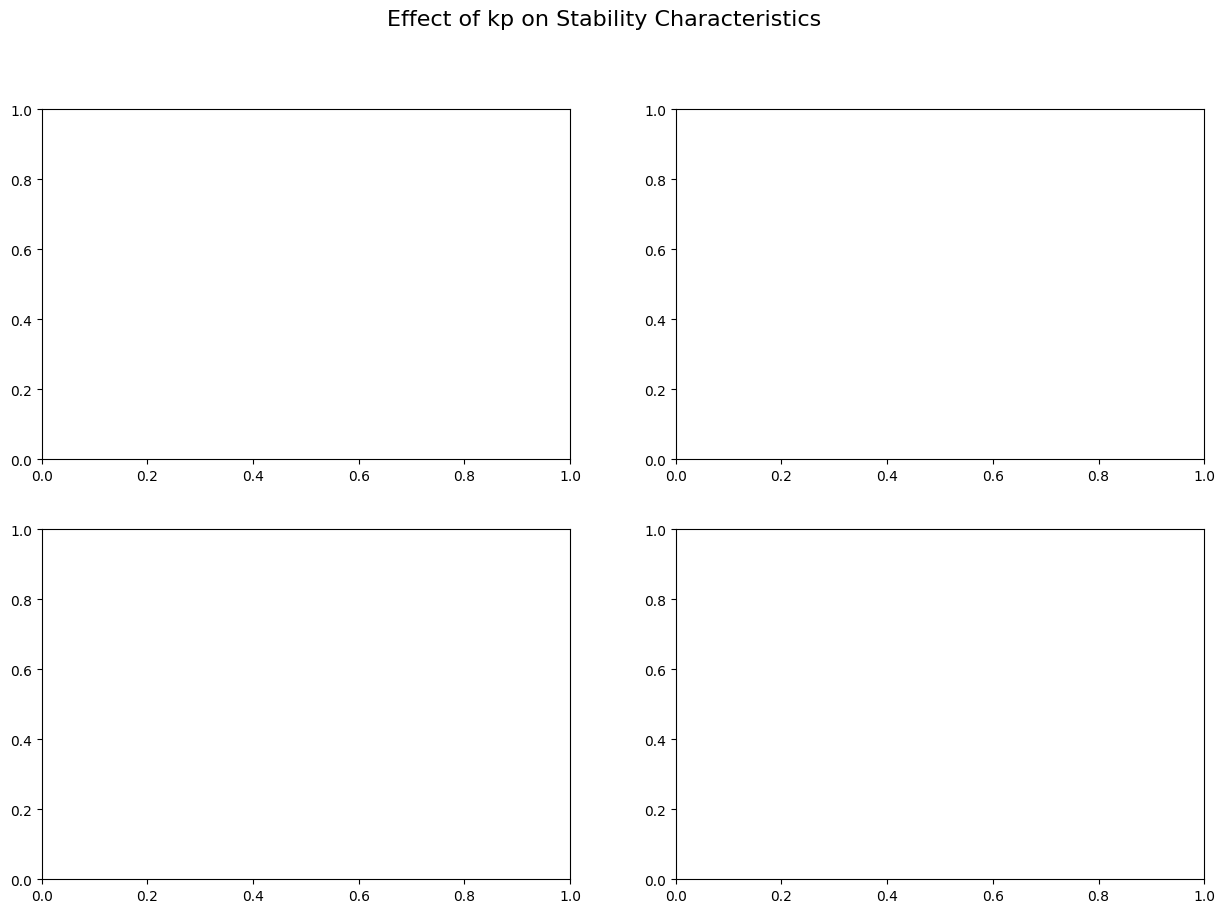

In [6]:
from aircraft_design.final_design.final_trade_studies.dynamic_stability_trade_study import analyze_aircraft_dynamic_stability, plot_gain_sensitivity

aircraft_dynamic_stability_copy = copy.deepcopy(empty_aircraft)



# find passive values
short_nf, short_df, p_nf, p_df, dnf, ddr, Tr, Ts = analyze_aircraft_dynamic_stability(aircraft_dynamic_stability_copy, visualize=False)

print(f"====== Passive values ====== \n short_nf: {short_nf:.2f}, short_df: {short_df:.2f}, p_nf: {p_nf:.2f}, p_df: {p_df:.2f}, dnf: {dnf:.2f}, ddr: {ddr:.2f}, Tr: {Tr:.2f}, Ts: {Ts:.2f}")

# currently these gains are bad
test_gains = {
        'ku': [0.0, -0.1], 'kw': [0, -.1], 'kq': [0, 0], 'ko_long': [0, 0],
        'kv': [0.4, 0], 'kp': [0.2,0], 'kr': [0.4, 0], 'ko_lat': [0, 0]
        #'kv': [0.4, 0], 'kp': [0.2,0], 'kr': [2, 0], 'ko_lat': [0, 0]
    }
# find augmented values
short_nf, short_df, p_nf, p_df, dnf, ddr, Tr, Ts = analyze_aircraft_dynamic_stability(aircraft_dynamic_stability_copy, **test_gains, visualize=False)
print(f"====== Augmented values ====== \n short_nf: {short_nf:.2f}, short_df: {short_df:.2f}, p_nf: {p_nf:.2f}, p_df: {p_df:.2f}, dnf: {dnf:.2f}, ddr: {ddr:.2f}, Tr: {Tr:.2f}, Ts: {Ts:.2f}")


#exit()
# plot long gain sensitivity
for gain in []:#['ku', 'kw', 'kq', 'ko_long']:
    plot_gain_sensitivity(aircraft_dynamic_stability_copy, gain, base_gains=test_gains)
    print(f"Finished {gain}")

#plot lat gain sensitivity
for gain in ['kp', 'kr', 'ko_lat', 'kv']:
    plot_gain_sensitivity(aircraft_dynamic_stability_copy, gain, base_gains=test_gains,num_points=5)
    print(f"Finished {gain}")

In [8]:
from aircraft_design.final_design.final_trade_studies.dynamic_stability_trade_study import optimize_longitudinal_gains, optimize_lateral_gains
gains = optimize_longitudinal_gains(aircraft_dynamic_stability_copy)
print(gains)

Longitudinal Cost: 12.89, short_nf: 1.23, short_df: 0.05, p_nf: 0.02, p_df: 0.13
Longitudinal Gains: [ 0.001 -0.001 -0.001 -0.001  0.001 -0.001  0.001  0.001]
Longitudinal Cost: 12.889999999999997, short_nf: 1.23, short_df: 0.05, p_nf: 0.02, p_df: 0.13
Longitudinal Gains: [ 0.00099999 -0.001      -0.001      -0.001       0.001      -0.001
  0.001       0.001     ]
Longitudinal Cost: 12.89, short_nf: 1.23, short_df: 0.05, p_nf: 0.02, p_df: 0.13
Longitudinal Gains: [ 0.001      -0.00099999 -0.001      -0.001       0.001      -0.001
  0.001       0.001     ]
Longitudinal Cost: 12.890000000000004, short_nf: 1.23, short_df: 0.05, p_nf: 0.02, p_df: 0.13
Longitudinal Gains: [ 0.001      -0.001      -0.00099999 -0.001       0.001      -0.001
  0.001       0.001     ]
Longitudinal Cost: 12.89, short_nf: 1.23, short_df: 0.05, p_nf: 0.02, p_df: 0.13
Longitudinal Gains: [ 0.001      -0.001      -0.001      -0.00099999  0.001      -0.001
  0.001       0.001     ]
Longitudinal Cost: 12.89, short_nf:

In [9]:
# prepare for optimization
#base_gains_lon = [test_gains['ku'][0], test_gains['ku'][1], test_gains['kw'][0], test_gains['kw'][1], test_gains['kq'][0], test_gains['kq'][1], test_gains['ko_long'][0], test_gains['ko_long'][1]]
base_gains_lat = [0.0578986, 0.06956373, -0.04380358, 0.06412914, 0.00955627, -0.03807618, 0.0166469, 0.06087993]

#optimize lat gains
gains = optimize_lateral_gains(aircraft_dynamic_stability_copy)#,base_gains=base_gains_lat)
print(gains)





Lateral Cost: 1.3142435920631275, dnf: 0.52, ddr: -0.01, Tr: 2.07, Ts: 87.68
Lateral Gains: [0. 0. 0. 0. 0. 0. 0. 0.]
Lateral Cost: 1.3142274804440055, dnf: 0.52, ddr: -0.01, Tr: 2.07, Ts: 87.68
Lateral Gains: [1.49011612e-08 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
Lateral Cost: 1.3142352650921547, dnf: 0.52, ddr: -0.01, Tr: 2.07, Ts: 87.68
Lateral Gains: [0.00000000e+00 1.49011612e-08 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
Lateral Cost: 1.3142436223473233, dnf: 0.52, ddr: -0.01, Tr: 2.07, Ts: 87.68
Lateral Gains: [0.00000000e+00 0.00000000e+00 1.49011612e-08 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
Lateral Cost: 1.314243533012001, dnf: 0.52, ddr: -0.01, Tr: 2.07, Ts: 87.68
Lateral Gains: [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.49011612e-08
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
Lateral Cost: 1.3142435

/home/dryogurt/Documents/Habitats/Aero-Design-Team-Gamma/aircraft_design/analysis/static_stability.py:790: RuntimeWarning: invalid value encountered in scalar divide
  'Cl_delta_a': Cl_delta_a/delta_a,  # Derivative
/home/dryogurt/.cache/pypoetry/virtualenvs/aerospace-design-team-gamma-QogS2DLM-py3.13/lib/python3.13/site-packages/scipy/signal/_ltisys.py:599: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  self.num, self.den = normalize(*system)


Lateral Cost: 62.03638475054456, dnf: 0.49, ddr: 0.09, Tr: 2.58, Ts: -198.72
Lateral Gains: [ 2.26177357e-03  7.76592881e-06  1.16872541e-02 -7.47229982e-02
 -5.89438744e-04  2.27089360e-02 -9.94139254e-03 -5.52417415e-02]
Lateral Cost: 292.27336677554734, dnf: 0.48, ddr: 0.09, Tr: 2.60, Ts: -465.17
Lateral Gains: [ 2.24558952e-03 -3.44844667e-05  1.29883787e-02 -7.25021940e-02
 -6.51553330e-04  2.13754679e-02 -1.19847568e-02 -5.18466470e-02]
Lateral Cost: 2519.036719531465, dnf: 0.48, ddr: 0.09, Tr: 2.61, Ts: -1421.59
Lateral Gains: [ 2.23749749e-03 -5.56096644e-05  1.36389411e-02 -7.13917919e-02
 -6.82610623e-04  2.07087338e-02 -1.30064389e-02 -5.01490998e-02]
Lateral Cost: 0.0037261264692608938, dnf: 0.48, ddr: 0.09, Tr: 2.61, Ts: 47779.03
Lateral Gains: [ 2.23345148e-03 -6.61722633e-05  1.39642223e-02 -7.08365908e-02
 -6.98139269e-04  2.03753668e-02 -1.35172800e-02 -4.93003261e-02]
Lateral Cost: 0.0037262920378007824, dnf: 0.48, ddr: 0.09, Tr: 2.61, Ts: 48891.04
Lateral Gains: [ 2.